In [24]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import resample  
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



file_path = '/Users/hrishiraj/Documents/MTech/NLP Project/OLIDv1.0 (1)/olid-training-v1.0.tsv' 

try:
    
    df = pd.read_csv(file_path, sep='\t',encoding='utf-8',quoting=3)
    print("File loaded successfully!")
    print('Loaded shape:', df.shape)
    print('Columns:', df.columns.tolist())
    print(df.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please make sure 'olid-training-v1.0.tsv' is in the same folder as your notebook.")
  
    raise

File loaded successfully!
Loaded shape: (13240, 5)
Columns: ['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c']
      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  "@USER Someone should'veTaken"" this piece of ...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  


## Preprocessing

In [25]:

print("\nStarting preprocessing...")
if 'tweet' in df.columns:
    
    df['clean_text'] = (
        df['tweet'].astype(str)
          .str.replace(r'http\S+|www\.\S+', '', regex=True) 
          .str.replace(r'@\w+', '', regex=True)           
          .str.replace(r'#', '', regex=True)                
          .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)     
          .str.replace(r'\s+', ' ', regex=True)            
          .str.strip()                               
          .str.lower()                                    
    )
    print("Preprocessing complete.")
    print(df[['tweet', 'clean_text']].head())
else:
    print("Error: 'tweet' column not found.")
  
    raise KeyError("'tweet' column not found in the DataFrame.")


Starting preprocessing...
Preprocessing complete.
                                               tweet  \
0  @USER She should ask a few native Americans wh...   
1  @USER @USER Go home you’re drunk!!! @USER #MAG...   
2  Amazon is investigating Chinese employees who ...   
3  "@USER Someone should'veTaken"" this piece of ...   
4  @USER @USER Obama wanted liberals &amp; illega...   

                                          clean_text  
0  she should ask a few native americans what the...  
1                go home you re drunk maga trump url  
2  amazon is investigating chinese employees who ...  
3  someone should vetaken this piece of shit to a...  
4  obama wanted liberals amp illegals to move int...  


##  Helper Functions

In [26]:

def plot_cm(y_true, y_pred, title, labels):
    """Helper function to plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.show()





In [27]:
def train_and_evaluate(X_train, y_train, X_test, y_test, stage_name, labels):
    """
    Trains and evaluates both LR and NB models for a given stage.
    Handles imbalance using the *same* upsampling method as your teammate.
    """
    print("\n" + "="*50)
    print(f"Running Models for: {stage_name}")
    print(f"Original training data shape: {X_train.shape}")
    print(f"Original class distribution:\n{y_train.value_counts()}")
    print("="*50 + "\n")

    # Upsampling minority classes to balance the dataset
    
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    max_size = train_df['label'].value_counts().max()

    balanced_df = pd.concat([
        resample(group,
                 replace=True,
                 n_samples=max_size,
                 random_state=RANDOM_STATE)
        for _, group in train_df.groupby('label')
    ], ignore_index=True)


    balanced_df = balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    X_train_bal = balanced_df['text']
    y_train_bal = balanced_df['label']
    
    print(f"Balanced training data shape: {X_train_bal.shape}")
    print(f"Balanced class distribution:\n{y_train_bal.value_counts()}")
    print("-" * 50)

    # TF-IDF Vectorizer parameters
    tfidf_params = dict(ngram_range=(1, 2), max_features=20000, min_df=5)

    # Model A: Logistic Regression Pipeline
    pipe_lr = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, max_iter=1000))
    ])

    # Model B: Naive Bayes Pipeline
    pipe_nb = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', MultinomialNB(alpha=1.0)) 
    ])

    
    
    print(f"\n MODEL A: LOGISTIC REGRESSION ({stage_name})")
    pipe_lr.fit(X_train_bal, y_train_bal)
    y_pred_lr = pipe_lr.predict(X_test)
    
    print("Classification Report (Logistic Regression):")
    print(classification_report(y_test, y_pred_lr, target_names=labels))
    plot_cm(y_test, y_pred_lr, f"LR Confusion Matrix ({stage_name})", labels)

    
  
    print(f"\n MODEL B: MULTINOMIAL NAIVE BAYES ({stage_name})")
    pipe_nb.fit(X_train_bal, y_train_bal)
    y_pred_nb = pipe_nb.predict(X_test)
    
    print("Classification Report (Naive Bayes):")
    print(classification_report(y_test, y_pred_nb, target_names=labels))
    plot_cm(y_test, y_pred_nb, f"NB Confusion Matrix ({stage_name})", labels)

## Stage 1: OFF vs NOT Classification


--- Starting Stage 1: OFF vs NOT ---
Stage 1 total samples: 13240
Stage 1 Train: 10592, Test: 2648

Running Models for: Stage 1
Original training data shape: (10592,)
Original class distribution:
y_a
0    7072
1    3520
Name: count, dtype: int64

Balanced training data shape: (14144,)
Balanced class distribution:
label
1    7072
0    7072
Name: count, dtype: int64
--------------------------------------------------

 MODEL A: LOGISTIC REGRESSION (Stage 1)
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         NOT       0.79      0.73      0.76      1768
         OFF       0.53      0.61      0.57       880

    accuracy                           0.69      2648
   macro avg       0.66      0.67      0.66      2648
weighted avg       0.70      0.69      0.69      2648



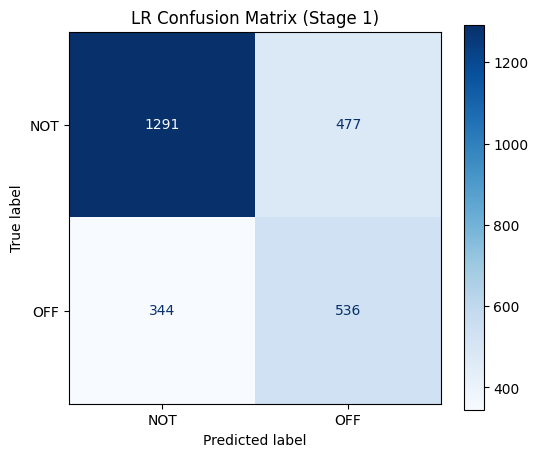


 MODEL B: MULTINOMIAL NAIVE BAYES (Stage 1)
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

         NOT       0.78      0.77      0.77      1768
         OFF       0.55      0.56      0.55       880

    accuracy                           0.70      2648
   macro avg       0.66      0.66      0.66      2648
weighted avg       0.70      0.70      0.70      2648



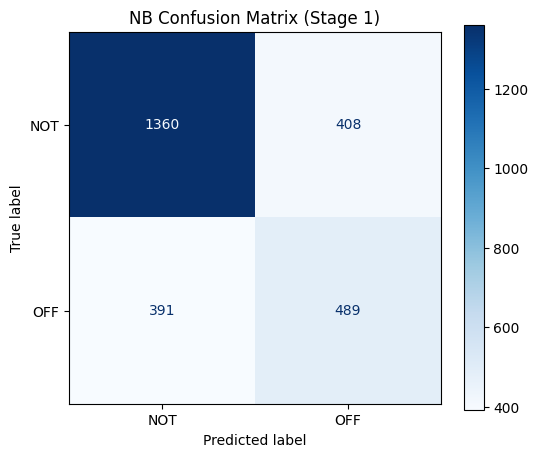

In [28]:

print("\n--- Starting Stage 1: OFF vs NOT ---")


label_map_a = {'NOT': 0, 'OFF': 1}
df_a = df[df['subtask_a'].isin(label_map_a.keys())].copy()
df_a['y_a'] = df_a['subtask_a'].map(label_map_a)
print(f"Stage 1 total samples: {df_a.shape[0]}")


X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    df_a['clean_text'], df_a['y_a'],
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=df_a['y_a']
)
print(f"Stage 1 Train: {len(X_train_a)}, Test: {len(X_test_a)}")


stage_1_labels = ['NOT', 'OFF']
train_and_evaluate(X_train_a, y_train_a, X_test_a, y_test_a, "Stage 1", stage_1_labels)

## Stage 2A: UNT vs TIN Classification


--- Starting Stage 2A: UNT vs TIN ---
Stage 2A total samples: 4400
y_b
1    3876
0     524
Name: count, dtype: int64
Stage 2A Train: 3520, Test: 880

Running Models for: Stage 2A
Original training data shape: (3520,)
Original class distribution:
y_b
1    3101
0     419
Name: count, dtype: int64

Balanced training data shape: (6202,)
Balanced class distribution:
label
1    3101
0    3101
Name: count, dtype: int64
--------------------------------------------------

 MODEL A: LOGISTIC REGRESSION (Stage 2A)
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         UNT       0.23      0.21      0.22       105
         TIN       0.89      0.91      0.90       775

    accuracy                           0.82       880
   macro avg       0.56      0.56      0.56       880
weighted avg       0.82      0.82      0.82       880



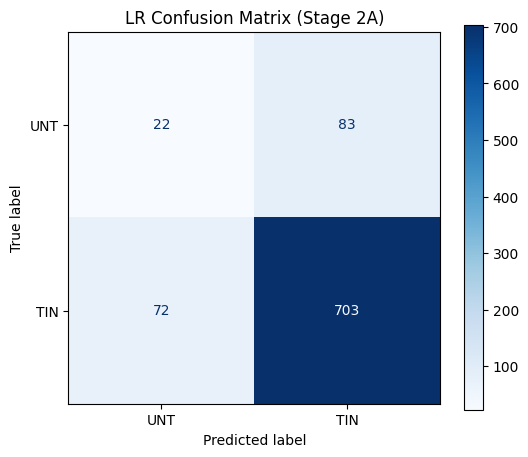


 MODEL B: MULTINOMIAL NAIVE BAYES (Stage 2A)
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

         UNT       0.31      0.09      0.13       105
         TIN       0.89      0.97      0.93       775

    accuracy                           0.87       880
   macro avg       0.60      0.53      0.53       880
weighted avg       0.82      0.87      0.83       880



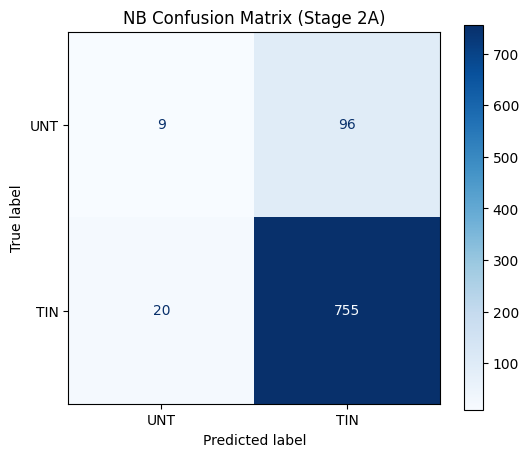

In [29]:

print("\n--- Starting Stage 2A: UNT vs TIN ---")


label_map_b = {'UNT': 0, 'TIN': 1}
if 'subtask_b' in df.columns:
    df_b = df[df['subtask_b'].isin(label_map_b.keys())].copy()
    df_b['y_b'] = df_b['subtask_b'].map(label_map_b)
    print(f"Stage 2A total samples: {df_b.shape[0]}")
    print(df_b['y_b'].value_counts())


    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
        df_b['clean_text'], df_b['y_b'],
        test_size=0.2, 
        random_state=RANDOM_STATE, 
        stratify=df_b['y_b']
    )
    print(f"Stage 2A Train: {len(X_train_b)}, Test: {len(X_test_b)}")


    stage_2a_labels = ['UNT', 'TIN']
    train_and_evaluate(X_train_b, y_train_b, X_test_b, y_test_b, "Stage 2A", stage_2a_labels)
else:
    print("Warning: 'subtask_b' not found. Skipping Stage 2A.")

## Stage 2B: IND vs GRP vs OTH Classification


--- Starting Stage 2B: IND vs GRP vs OTH ---
Stage 2B total samples: 3876
y_c
0    2407
1    1074
2     395
Name: count, dtype: int64
Stage 2B Train: 3100, Test: 776

Running Models for: Stage 2B
Original training data shape: (3100,)
Original class distribution:
y_c
0    1925
1     859
2     316
Name: count, dtype: int64

Balanced training data shape: (5775,)
Balanced class distribution:
label
2    1925
0    1925
1    1925
Name: count, dtype: int64
--------------------------------------------------

 MODEL A: LOGISTIC REGRESSION (Stage 2B)
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         IND       0.81      0.75      0.78       482
         GRP       0.52      0.64      0.57       215
         OTH       0.23      0.19      0.21        79

    accuracy                           0.66       776
   macro avg       0.52      0.52      0.52       776
weighted avg       0.67      0.66      0.66       776



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


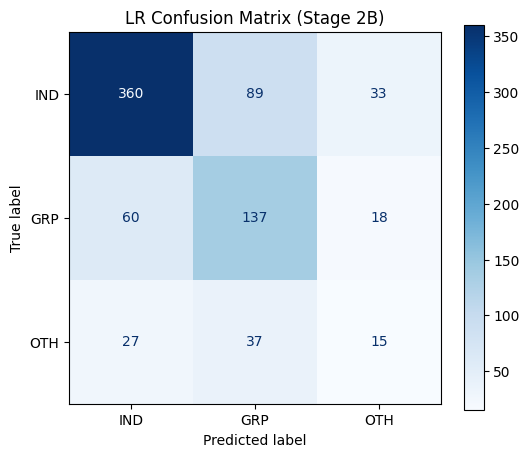


 MODEL B: MULTINOMIAL NAIVE BAYES (Stage 2B)
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

         IND       0.76      0.81      0.78       482
         GRP       0.50      0.57      0.53       215
         OTH       0.10      0.03      0.04        79

    accuracy                           0.66       776
   macro avg       0.45      0.47      0.45       776
weighted avg       0.62      0.66      0.64       776



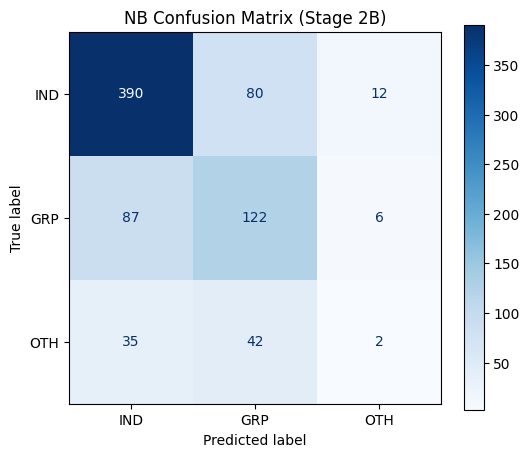

In [31]:

print("\n--- Starting Stage 2B: IND vs GRP vs OTH ---")


label_map_c = {'IND': 0, 'GRP': 1, 'OTH': 2}
if 'subtask_c' in df.columns:
    df_c = df[df['subtask_c'].isin(label_map_c.keys())].copy()
    df_c['y_c'] = df_c['subtask_c'].map(label_map_c)
    print(f"Stage 2B total samples: {df_c.shape[0]}")
    print(df_c['y_c'].value_counts())

    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        df_c['clean_text'], df_c['y_c'],
        test_size=0.2, 
        random_state=RANDOM_STATE, 
        stratify=df_c['y_c']
    )
    print(f"Stage 2B Train: {len(X_train_c)}, Test: {len(X_test_c)}")


    stage_2b_labels = ['IND', 'GRP', 'OTH']
    train_and_evaluate(X_train_c, y_train_c, X_test_c, y_test_c, "Stage 2B", stage_2b_labels)
else:
    print("Warning: 'subtask_c' not found. Skipping Stage 2B.")


To ensure a valid comparison, all models were subjected to identical preprocessing, data splitting (80% train, 20% test), and training data balancing (upsampling) methodologies.
The analysis concludes that DistilBERT is the superior model, demonstrating significantly higher performance and balance on the primary binary (Stage 1) and complex multi-class (Stage 2B) tasks. Logistic Regression served as a strong baseline, consistently outperforming Naive Bayes. Multinomial Naive Bayes was the weakest performer, proving unreliable due to its severe difficulty in handling imbalanced class distributions.


Stage 1: Binary Classification (NOT vs. OFF)

This initial stage served as the primary filter for identifying offensive content.
* Dataset: The training set consisted of 10,592 samples, which were imbalanced between "NOT" (7,072) and "OFF" (3,520).
* Balancing: The training data was upsampled to a balanced set of 14,144 samples (7,072 per class) for all models.
* Test Set: 2,648 samples (1,768 NOT, 880 OFF).
<!-- 
Performance Comparison (Stage 1)

Model	           Weighted F1-Score	"OFF" Class Recall      	"OFF" Class F1-Score

DistilBERT	  -            0.78	              0.72	                      0.68

Log. Regression	 -         0.69	              0.61	                      0.57

Naive Bayes	      -        0.70	              0.56	                      0.55 -->

Analysis: DistilBERT demonstrated superior performance. Its F1-score for the critical "OFF" class (0.68) was 11-13 points higher than the classical models. This translates to a significantly higher identification rate, with DistilBERT correctly identifying 632 of the 880 offensive samples, compared to 536 for LR and 493 for NB.


Stage 2A: Binary Classification (UNT vs. TIN)

This stage classified the nature of the abuse as either untargeted (UNT) or targeted (TIN).
* Dataset: This task was highly imbalanced, with 3,520 training samples split between "UNT" (419) and "TIN" (3,101).
* Balancing: The training data was upsampled to 6,202 samples (3,101 per class).
* Test Set: 880 samples (105 UNT, 775 TIN).
<!-- 
Performance Comparison (Stage 2A)

Model	           Weighted F1-Score	"UNT" (Minority) F1-Score	   "UNT" (Minority) Recall

DistilBERT	              0.82	              0.16	                      0.12

Log. Regression	          0.82	              0.22	                      0.21

Naive Bayes	              0.83	              0.13	                      0.09 -->

Analysis: Logistic Regression achieved the highest F1-score (0.22) and Recall (0.21) for the minority "UNT" class, slightly outperforming DistilBERT (0.16 F1). The high Weighted F1 of Naive Bayes (0.83) is misleading, as it was achieved by heavily favoring the majority class (97% recall) while almost completely failing to identify the minority class (9% recall).


Stage 2B: Multi-Class Classification (IND vs. GRP vs. OTH)

This final stage categorized the target of the abuse as Individual (IND), Group (GRP), or Other (OTH).
* Dataset: The 3,100-sample training set was imbalanced: 1,925 "IND", 859 "GRP", and 316 "OTH".
* Balancing: The training data was upsampled to 5,775 samples (1,925 per class).
* Test Set: 776 samples (482 IND, 215 GRP, 79 OTH).

<!-- Performance Comparison (Stage 2B)

Model	           Weighted F1-Score	 Macro F1-Score	               "OTH" (Minority) Recall

DistilBERT	              0.69	              0.54	                      0.16

Log. Regression	          0.66	              0.52	                      0.19

Naive Bayes	              0.64	              0.45	                      0.03 -->

Analysis: DistilBERT provided the best overall balance, achieving the highest Macro F1-Score (0.54), which is the most important metric for a multi-class imbalanced task. Logistic Regression was a close second (0.52). Naive Bayes performed very poorly, with its Macro F1 suffering from a near-total failure to identify the "OTH" class (3% recall).
